# Data Preparation

**Brazilian E-Commerce Public Dataset by Olist**

## Load Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from datetime import datetime as dt

from wordcloud import WordCloud, STOPWORDS

# To visualize the geographical coordinates in the world map
import folium
from folium.plugins import HeatMap

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/Final_Projek_Olist_Dataset/dataset/"

# Load datasets
orders = pd.read_csv(data_path + "olist_orders_dataset.csv")
payments = pd.read_csv(data_path + "olist_order_payments_dataset.csv")
customers = pd.read_csv(data_path + "olist_customers_dataset.csv")
orderItems = pd.read_csv(data_path + "olist_order_items_dataset.csv")
products = pd.read_csv(data_path + "olist_products_dataset.csv")
sellers = pd.read_csv(data_path + "olist_sellers_dataset.csv")
geolocation = pd.read_csv(data_path + "olist_geolocation_dataset.csv")
reviews = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")

productCategoryTranslation = pd.read_csv(data_path + "product_category_name_translation.csv")

### Local

In [3]:
data_path = "../dataset/"

# Load datasets
orders = pd.read_csv(data_path + "olist_orders_dataset.csv")
payments = pd.read_csv(data_path + "olist_order_payments_dataset.csv")
customers = pd.read_csv(data_path + "olist_customers_dataset.csv")
orderItems = pd.read_csv(data_path + "olist_order_items_dataset.csv")
products = pd.read_csv(data_path + "olist_products_dataset.csv")
sellers = pd.read_csv(data_path + "olist_sellers_dataset.csv")
geolocation = pd.read_csv(data_path + "olist_geolocation_dataset.csv")
reviews = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")

productCategoryTranslation = pd.read_csv(data_path + "product_category_name_translation.csv")

## Overview Data

In [ ]:
def detailed_dataset_summary(dataset_name, data):
    summary = pd.DataFrame({
        'dataset_name': dataset_name,
        'feature': data.columns,
        'qtd_null': data.isna().sum().values,  # Null value count
        'percent_null': (data.isna().mean() * 100).values,  # Null percentage
        'dtype': data.dtypes.values,  # Data type
        'qtd_cat': [
            data[col].nunique() if data[col].dtype == 'object' else 0
            for col in data.columns
        ]  # Total categorical entries
    }).round(6)

    return summary

In [ ]:
# Create a dictionary with all datasets
datasets = {
    "orders": orders,
    "customer": customers,
    "geolocation": geolocation,
    "orders": orders,
    "order_items": orderItems,
    "payments": payments,
    "reviews": reviews,
    "products": products,
    "sellers": sellers,
    "product_category_translation": productCategoryTranslation
}

# Generate detailed summaries for each dataset
all_summaries = [detailed_dataset_summary(name, df) for name, df in datasets.items()]

# Combine all summaries into one DataFrame
combined_summary = pd.concat(all_summaries, ignore_index=True)

# Display with styling
styled_summary = (
    combined_summary.style
    .background_gradient(subset=['percent_null'], cmap='Reds')
    .set_properties(**{'text-align': 'center'})
    .set_caption("Detailed Column Summary for All Olist Datasets")
    .hide(axis='index')  # Use this instead of .hide_index()
)

display(styled_summary)


dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
orders,order_id,0,0.000000,object,99441
orders,customer_id,0,0.000000,object,99441
orders,order_status,0,0.000000,object,8
orders,order_purchase_timestamp,0,0.000000,object,98875
orders,order_approved_at,160,0.160899,object,90733
orders,order_delivered_carrier_date,1783,1.793023,object,81018
orders,order_delivered_customer_date,2965,2.981668,object,95664
orders,order_estimated_delivery_date,0,0.000000,object,459
customer,customer_id,0,0.000000,object,99441
customer,customer_unique_id,0,0.000000,object,96096


*Insight*

Missing Data Issues:

The reviews dataset has high missing values:
review_comment_title (88.34%)
review_comment_message (58.70%)
Some fields in orders have missing timestamps, e.g.,
order_delivered_carrier_date (1.79%)
order_delivered_customer_date (2.98%)
Products dataset has ~1.85% missing in category name, description length, and photo quantity.

## *Data Cleaning*

In [ ]:
#Fill missing values in 'orders' dataset
if "orders" in datasets:
    orders = datasets["orders"]

    # Convert date columns to datetime
    date_cols = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_estimated_delivery_date"]
    for col in date_cols:
        if col in orders:
            orders[col] = pd.to_datetime(orders[col])

    # Calculate median processing time from approval to carrier delivery
    median_processing_time = (orders["order_delivered_carrier_date"] - orders["order_approved_at"]).median()

    # Fill missing 'order_delivered_carrier_date' using 'order_approved_at' + median processing time
    orders["order_delivered_carrier_date"].fillna(orders["order_approved_at"] + median_processing_time, inplace=True)

    # Fill other missing values
    fill_values_orders = {
        "order_approved_at": orders["order_purchase_timestamp"].mode()[0] if "order_purchase_timestamp" in orders else None,
        "order_delivered_customer_date": orders["order_estimated_delivery_date"].mode()[0] if "order_estimated_delivery_date" in orders else None,
    }
    orders.fillna({k: v for k, v in fill_values_orders.items() if v is not None}, inplace=True)


#Handling missing value for 'Reviews'
if "reviews" in datasets:
    reviews = datasets["reviews"]
    fill_values_reviews = {
        "review_score": reviews["review_score"].median() if "review_score" in reviews else 3,
        "review_comment_message": "nao_reveja" if "review_comment_message" in reviews else None,
    }
    reviews.fillna({k: v for k, v in fill_values_reviews.items() if v is not None}, inplace=True)
    reviews.drop(columns=["review_comment_title", "review_comment_message"], errors="ignore", inplace=True)


#Fill missing product descriptions & weight with median
if "products" in datasets:
    products = datasets["products"]
    fill_values_products = {
        "product_name_lenght": products["product_name_lenght"].median() if "product_name_lenght" in products else None,
        "product_description_lenght": products["product_description_lenght"].median() if "product_description_lenght" in products else None,
        "product_photos_qty": products["product_photos_qty"].median() if "product_photos_qty" in products else None,
        "product_weight_g": products["product_weight_g"].median() if "product_weight_g" in products else None,
        "product_length_cm": products["product_length_cm"].median() if "product_length_cm" in products else None,
        "product_height_cm": products["product_height_cm"].median() if "product_height_cm" in products else None,
        "product_width_cm": products["product_width_cm"].median() if "product_width_cm" in products else None,
    }
    products.fillna({k: v for k, v in fill_values_products.items() if v is not None}, inplace=True)
    products.fillna({"product_category_name": "Unknown"}, inplace=True)

# Fill missing values for 'payments' dataset if it exists
if "payments" in datasets:
    payments = datasets["payments"]
    payments.fillna({"payment_value": payments["payment_value"].median() if "payment_value" in payments else None}, inplace=True)

<ipython-input-29-124651a273b5>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders["order_delivered_carrier_date"].fillna(orders["order_approved_at"] + median_processing_time, inplace=True)


In [ ]:
# Generate detailed summaries for each dataset
all_summaries = [detailed_dataset_summary(name, df) for name, df in datasets.items()]

# Combine all summaries into one DataFrame
combined_summary = pd.concat(all_summaries, ignore_index=True)

# Display with styling
styled_summary = (
    combined_summary.style
    .background_gradient(subset=['percent_null'], cmap='Reds')
    .set_properties(**{'text-align': 'center'})
    .set_caption("Detailed Column Summary for All Olist Datasets")
    .hide(axis='index')  # Use this instead of .hide_index()
)

display(styled_summary)

dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
orders,order_id,0,0.000000,object,99441
orders,customer_id,0,0.000000,object,99441
orders,order_status,0,0.000000,object,8
orders,order_purchase_timestamp,0,0.000000,datetime64[ns],0
orders,order_approved_at,0,0.000000,datetime64[ns],0
orders,order_delivered_carrier_date,146,0.146821,datetime64[ns],0
orders,order_delivered_customer_date,0,0.000000,object,95665
orders,order_estimated_delivery_date,0,0.000000,datetime64[ns],0
customer,customer_id,0,0.000000,object,99441
customer,customer_unique_id,0,0.000000,object,96096


*Insight*

- Orders: Converts date columns, fills missing order_delivered_carrier_date using median processing time, and imputes categorical values with mode.

- Reviews: Fills missing scores with median, replaces empty comments with "nao_reveja", and drops sparse columns.

- Products: Uses median for missing product details and assigns "Unknown" to missing categories.

- Payments: Fills missing payment_value with median.

## Merging Data (without Geolocation)

In [ ]:
def merge_datasets():
    df = customers.merge(orders, on='customer_id', how='left') \
                  .merge(orderItems, on='order_id', how='left') \
                  .merge(products, on='product_id', how='left') \
                  .merge(productCategoryTranslation, on='product_category_name', how='left') \
                  .merge(sellers, on='seller_id', how='left') \
                  .merge(payments, on='order_id', how='left') \
                  .merge(reviews, on='order_id', how='left')

    return df

# Execute function
merged = merge_datasets()

# Preview the merged dataset
merged.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,itaquaquecetuba,SP,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,itajai,SC,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,itaquaquecetuba,SP,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5.0,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,itaquaquecetuba,SP,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,ibitinga,SP,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5.0,2018-08-10 00:00:00,2018-08-17 01:59:52


In [ ]:
print(merged.shape)
print(merged.info())

(119143, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  object        
 4   customer_state                 119143 non-null  object        
 5   order_id                       119143 non-null  object        
 6   order_status                   119143 non-null  object        
 7   order_purchase_timestamp       119143 non-null  datetime64[ns]
 8   order_approved_at              119143 non-null  datetime64[ns]
 9   order_delivered_carrier_date   118981 non-null  datetime64[ns]
 10  order_delivered_customer_date  119143 non-null  object 

In [ ]:
# Convert pd datetime
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
merged['order_approved_at'] = pd.to_datetime(merged['order_approved_at'])
merged['order_delivered_carrier_date'] = pd.to_datetime(merged['order_delivered_carrier_date'])
merged['order_delivered_customer_date'] = pd.to_datetime(merged['order_delivered_customer_date'])
merged['order_estimated_delivery_date'] = pd.to_datetime(merged['order_estimated_delivery_date'])

In [ ]:
# Ensure datetime conversion first
merged['purchased_approved'] = (merged['order_approved_at'] - merged['order_purchase_timestamp']).dt.seconds
merged['approved_carrier'] = (merged['order_delivered_carrier_date'] - merged['order_approved_at']).dt.days
merged['carrier_delivered'] = (merged['order_delivered_customer_date'] - merged['order_delivered_carrier_date']).dt.days
merged['delivered_estimated'] = (merged['order_estimated_delivery_date'] - merged['order_delivered_customer_date']).dt.days
merged['purchased_delivered'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days

# Preview the updated merged DataFrame
merged.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,purchased_approved,approved_carrier,carrier_delivered,delivered_estimated,purchased_delivered
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,2017-05-26 00:00:00,2017-05-30 22:34:40,997,6.0,1.0,10,8
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,2018-01-30 00:00:00,2018-02-10 22:43:29,608,2.0,13.0,7,16
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,157.73,5ad6695d76ee186dc473c42706984d87,5.0,2018-06-15 00:00:00,2018-06-15 12:10:59,685,21.0,3.0,-2,26
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,2018-03-29 00:00:00,2018-04-02 18:36:47,4961,14.0,0.0,12,14
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,252.25,8490879d58d6c5d7773f2739a03f089a,5.0,2018-08-10 00:00:00,2018-08-17 01:59:52,1119,1.0,10.0,5,11


In [ ]:
# Define columns to drop
cols_to_drop = [
    'order_status', 'order_item_id', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date', 'approved_carrier',
    'carrier_delivered', 'seller_id', 'shipping_limit_date', 'product_category_name',
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
    'geolocation_zip_code_prefix', 'payment_sequential', 'seller_zip_code_prefix',
    'review_id', 'review_comment_title', 'review_comment_message',
    'review_creation_date', 'review_answer_timestamp', 'seller_city', 'seller_state'
]

# Drop specified columns
merged.drop(columns=cols_to_drop, axis = 1, inplace=True, errors='ignore')

# Display first few rows
merged.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,product_id,price,freight_value,...,product_height_cm,product_width_cm,product_category_name_english,payment_type,payment_installments,payment_value,review_score,purchased_approved,delivered_estimated,purchased_delivered
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,...,64.0,31.0,office_furniture,credit_card,2.0,146.87,4.0,997,10,8
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,...,15.0,40.0,housewares,credit_card,8.0,335.48,5.0,608,7,16
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,...,52.0,17.0,office_furniture,credit_card,7.0,157.73,5.0,685,-2,26
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,...,51.0,28.0,office_furniture,credit_card,1.0,173.30,5.0,4961,12,14
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,...,15.0,35.0,home_confort,credit_card,8.0,252.25,5.0,1119,5,11


In [ ]:
print(merged.shape)
print(merged.info())

(119143, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  object        
 4   customer_state                 119143 non-null  object        
 5   order_id                       119143 non-null  object        
 6   order_purchase_timestamp       119143 non-null  datetime64[ns]
 7   product_id                     118310 non-null  object        
 8   price                          118310 non-null  float64       
 9   freight_value                  118310 non-null  float64       
 10  product_weight_g               118310 non-null  float64

In [ ]:
# to save the grouped-by dataframe as a new csv for future usage.
merged.to_csv('merged_without_geolocation.csv')

*Insight*

- Comprehensive Data Integration: Merges customer, order, product, payment, and review data, ensuring all relevant attributes are combined.

- Datetime Transformations: Converts timestamps to datetime and creates new

- Duration features:

1. purchased_approved: Time from order purchase to approval (seconds).
approved_carrier: Days from approval to carrier pickup.
2. carrier_delivered: Days from carrier pickup to customer delivery.
3. delivered_estimated: Difference between actual and estimated delivery.
purchased_delivered: Total time from purchase to delivery.

- Feature Reduction: Drops redundant or less useful columns (e.g., timestamps, categorical details, geolocation, review text) to reduce data complexity and improve model performance.

## Creating RFM Data

RFM analysis is a data driven customer behavior segmentation technique.


RFM stands for recency, frequency, and monetary value.


The idea is to segment customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall. All three of these measures have proven to be effective predictors of a customer's willingness to engage in marketing messages and offers

### Recency

In [ ]:
recency = merged.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'},inplace = True)
recency.head()

,customer_unique_id,LastPurchaseDate
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [ ]:
recent_date = merged['order_purchase_timestamp'].dt.date.max()
print('The last recent date in the available dataset is: ', recent_date)

The last recent date in the available dataset is:  2018-10-17


In [ ]:
recency['Recency'] = recency['LastPurchaseDate'].dt.date.apply(lambda x: (recent_date - x).days)
recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,586
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,370
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,337


### Frequency

In [ ]:
frequency = merged.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={'order_id':'Frequency'},inplace=True)
frequency.head(100)

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95,003c2067070f5b3d923235b1ea1cc17b,1
96,003c457932a554e4df13834237b1ed00,1
97,003d56767e53e08671de00da3fba8d40,1
98,003db7adfcdc49857b095a50191b6c9d,1


### Monetary

In [ ]:
monetary = merged.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.rename(columns={'payment_value':'Monetary'},inplace=True)
monetary.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [ ]:
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89


*Insight*

RFM (Recency, Frequency, Monetary) segmentation helps identify customer purchasing behavior:

- Recency: Days since the last purchase—lower values indicate active customers.
- Frequency: Number of unique purchases—higher frequency suggests loyalty.
- Monetary: Total spending—higher values indicate high-value customers.

The dataset is aggregated using groupby, converting timestamps into actionable insights. This structured approach enables targeted marketing and customer retention strategies

# Customer Segmentation Labelling

## Recency Label

In [ ]:
ll_r = rfm.Recency.quantile(0.25)
mid_r = rfm.Recency.quantile(0.50)
ul_r = rfm.Recency.quantile(0.75)
print(ll_r, mid_r, ul_r)

164.0 269.0 397.0


In [ ]:
def recency_label(recent):
    if recent <= ll_r:
        return 1
    elif (recent > ll_r) and (recent <= mid_r):
        return 2
    elif (recent > mid_r) and (recent <= ul_r):
        return 3
    elif recent > ul_r:
        return 4

In [ ]:
rfm['recency_label'] = rfm.Recency.apply(recency_label)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,recency_label
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1
2,0000f46a3911fa3c0805444483337064,586,1,86.22,4
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3


## Frequency Label

In [ ]:
rfm.Frequency.value_counts()

,count
Frequency,
1,93099
2,2745
3,203
4,30
5,8
6,6
7,3
9,1
17,1


In [ ]:
def frequency_label(frequent):
    if frequent == 1:
        return 4
    elif frequent == 2:
        return 3
    elif frequent == 3:
        return 2
    elif frequent > 3:
        return 1

In [ ]:
rfm['frequency_label'] = rfm.Frequency.apply(frequency_label)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,recency_label,frequency_label
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4
2,0000f46a3911fa3c0805444483337064,586,1,86.22,4,4
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3,4
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3,4


## Monetary label

In [ ]:
ll_m = rfm.Monetary.quantile(0.25)
mid_m = rfm.Monetary.quantile(0.50)
ul_m = rfm.Monetary.quantile(0.75)
print(ll_m, mid_m, ul_m)

64.0 113.34 203.42249999999999


In [ ]:
def monetary_label(money):
    if money <= ll_m:
        return 4
    elif (money > ll_m) and (money <= mid_m):
        return 3
    elif (money > mid_m) and (money <= ul_m):
        return 2
    elif money > ul_m:
        return 1

In [ ]:
rfm['monetary_label'] = rfm.Monetary.apply(monetary_label)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,recency_label,frequency_label,monetary_label
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4
2,0000f46a3911fa3c0805444483337064,586,1,86.22,4,4,3
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3,4,4
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3,4,2


## Rank List

Frequency label breakdown:

1 - These are the most frequent customers. (Frequency > 3)

2 - These are the frequent frequent customers. (Frequency = 3)

3 - These are the somewhat frequent customers. (Frequency = 2)

4 - These are the least frequent customers. (Frequency = 1)

In [ ]:
rfm['Rank'] = list(zip(rfm.recency_label, rfm.monetary_label, rfm.frequency_label))
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,recency_label,frequency_label,monetary_label,Rank
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2,"(1, 2, 4)"
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4,"(1, 4, 4)"
2,0000f46a3911fa3c0805444483337064,586,1,86.22,4,4,3,"(4, 3, 4)"
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3,4,4,"(3, 4, 4)"
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3,4,2,"(3, 2, 4)"


In [ ]:
rfm.recency_label.value_counts()

,count
recency_label,
1,24184
4,24009
2,23997
3,23906


In [ ]:
rfm.frequency_label.value_counts()

,count
frequency_label,
4,93099
3,2745
2,203
1,49


In [ ]:
rfm.monetary_label.value_counts()

,count
monetary_label,
4,24079
1,24024
2,24021
3,23972


In [ ]:
rfm['rank_rm'] = list(zip(rfm.recency_label, rfm.monetary_label))
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,recency_label,frequency_label,monetary_label,Rank,rank_rm
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2,"(1, 2, 4)","(1, 2)"
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4,"(1, 4, 4)","(1, 4)"
2,0000f46a3911fa3c0805444483337064,586,1,86.22,4,4,3,"(4, 3, 4)","(4, 3)"
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3,4,4,"(3, 4, 4)","(3, 4)"
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3,4,2,"(3, 2, 4)","(3, 2)"


In [ ]:
rfm.rank_rm.value_counts()

,count
rank_rm,
"(1, 2)",6230
"(4, 3)",6160
"(3, 3)",6121
"(4, 4)",6120
"(2, 2)",6114
"(1, 1)",6108
"(2, 4)",6064
"(3, 1)",6015
"(1, 4)",5994


## Meaning of ranks:

RFM segmentation assigns customers into ranked groups based on Recency (R), Frequency (F), and Monetary (M) value to identify high-value customers and those needing re-engagement.

- The most important and least important customers (Recency Rank, Monetary Rank):

- Comparing Recency and Monetary - Recency rank is of higher importance than Monetary rank

The most important ranks:

1. (Recency - 1, Monetary - 1) - They are very recent and have spend a lot of money

2. (Recency - 1, Monetary - 2) - They are very recent and have spend a good amount of money

3. (Recency - 2, Monetary - 1) - They are recent and have spend a lot of money

4. (Recency - 2, Monetary - 2) - They are recent and have spend a good of money

5. (Recency - 1, Monetary - 3) - They are very recent and have spend a decent of money

The least important ranks:

1. (Recency - 4, Monetary - 4) - They are not at all recent and spend a negligible amount of money

2. (Recency - 4, Monetary - 3) - They are not at all recent and spend a a decent amount of money

3. (Recency - 4, Monetary - 2) - They are not at all recent and spend a good amount of money

4. (Recency - 3, Monetary - 4) - They are not very recent and spend a negligible amount of money

5. (Recency - 3, Monetary - 3) - They are not very recent and spend a decent amount of money

# Creating Final Data

### Merging Data with Geolocation

*Run it locally, cause its too big for colab to handle*

In [ ]:
# def merge_datasets():
#     df = customers.merge(orders, on='customer_id', how='left') \
#                   .merge(orderItems, on='order_id', how='left') \
#                   .merge(products, on='product_id', how='left') \
#                   .merge(productCategoryTranslation, on='product_category_name', how='left') \
#                   .merge(sellers, on='seller_id', how='left') \
#                   .merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left') \
#                   .merge(payments, on='order_id', how='left') \
#                   .merge(reviews, on='order_id', how='left')

#     return df

# # Execute function
# merged = merge_datasets()

# # Preview the merged dataset
# merged.head()

In [ ]:
# print(merged.shape)
# print(merged.info())

In [ ]:
# # Convert relevant columns to datetime format in the merged DataFrame
# merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
# merged['order_approved_at'] = pd.to_datetime(merged['order_approved_at'])
# merged['order_delivered_carrier_date'] = pd.to_datetime(merged['order_delivered_carrier_date'])
# merged['order_delivered_customer_date'] = pd.to_datetime(merged['order_delivered_customer_date'])
# merged['order_estimated_delivery_date'] = pd.to_datetime(merged['order_estimated_delivery_date'])


In [ ]:
# # Ensure datetime conversion first
# merged['purchased_approved'] = (merged['order_approved_at'] - merged['order_purchase_timestamp']).dt.seconds
# merged['approved_carrier'] = (merged['order_delivered_carrier_date'] - merged['order_approved_at']).dt.days
# merged['carrier_delivered'] = (merged['order_delivered_customer_date'] - merged['order_delivered_carrier_date']).dt.days
# merged['delivered_estimated'] = (merged['order_estimated_delivery_date'] - merged['order_delivered_customer_date']).dt.days
# merged['purchased_delivered'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days

# # Preview the updated merged DataFrame
# merged.head()


In [ ]:
# # Define columns to drop
# cols_to_drop = [
#     'order_status', 'order_item_id', 'order_approved_at', 'order_delivered_carrier_date',
#     'order_delivered_customer_date', 'order_estimated_delivery_date', 'approved_carrier',
#     'carrier_delivered', 'seller_id', 'shipping_limit_date', 'product_category_name',
#     'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
#     'geolocation_zip_code_prefix', 'payment_sequential', 'seller_zip_code_prefix',
#     'review_id', 'review_comment_title', 'review_comment_message',
#     'review_creation_date', 'review_answer_timestamp', 'seller_city', 'seller_state'
# ]

# # Drop specified columns
# merged.drop(columns=cols_to_drop, axis = 1, inplace=True, errors='ignore')

# # Display first few rows
# merged.head()

In [ ]:
# final = merged.groupby('customer_unique_id', as_index=False).agg({'customer_zip_code_prefix'      : 'max',
#                                                                   'customer_city'                 : 'max',
#                                                                   'customer_state'                : 'max',
#                                                                   'order_id'                      : 'nunique',
#                                                                   'purchased_approved'            : 'mean',
#                                                                   'delivered_estimated'           : 'min',
#                                                                   'purchased_delivered'           : 'mean',
#                                                                   'product_id'                    : 'nunique',
#                                                                   'price'                         : 'sum',
#                                                                   'freight_value'                 : 'sum',
#                                                                   'product_weight_g'              : 'sum',
#                                                                   'product_length_cm'             : 'sum',
#                                                                   'product_height_cm'             : 'sum',
#                                                                   'product_width_cm'              : 'sum',
#                                                                   'geolocation_lat'               : 'mean',
#                                                                   'geolocation_lng'               : 'mean',
#                                                                   'payment_type'                  : 'max',
#                                                                   'payment_installments'          : 'max',
#                                                                   'payment_value'                 : 'sum',
#                                                                   'review_score'                  : 'mean'})

# final.head()

In [ ]:
# final['customer_zip_code_prefix'] = final.customer_zip_code_prefix.astype('object')

In [ ]:
# final.shape

In [ ]:
# final.info()

In [ ]:
# # to save the grouped-by dataframe as a new csv for future usage.
# final.to_csv('final.csv')

### Load Final Data

In [ ]:
final = pd.read_csv(data_path + "final.csv")

In [ ]:
final.shape

(96096, 22)

### Creating target variable

In [ ]:
rfm['Churn'] = rfm.Recency.apply(lambda x: 1 if x > rfm.Recency.mean() else 0)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,recency_label,frequency_label,monetary_label,Rank,rank_rm,Churn
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2,"(1, 2, 4)","(1, 2)",0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4,"(1, 4, 4)","(1, 4)",0
2,0000f46a3911fa3c0805444483337064,586,1,86.22,4,4,3,"(4, 3, 4)","(4, 3)",1
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3,4,4,"(3, 4, 4)","(3, 4)",1
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3,4,2,"(3, 2, 4)","(3, 2)",1


In [ ]:
final = final.merge(rfm[['customer_unique_id', 'Recency', 'Monetary', 'Frequency', 'Churn']], on = 'customer_unique_id')
final.head()

,Unnamed: 0,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,purchased_approved,delivered_estimated,purchased_delivered,product_id,...,geolocation_lat,geolocation_lng,payment_type,payment_installments,payment_value,review_score,Recency,Monetary,Frequency,Churn
0,0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1,891.0,4,6.0,1,...,-23.340235,-46.830140,credit_card,8.0,9365.40,5.0,160,141.90,1,0
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1,26057.0,4,3.0,1,...,-23.559115,-46.787626,credit_card,1.0,3915.36,4.0,163,27.19,1,0
2,2,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1,0.0,1,25.0,1,...,-27.542880,-48.633426,credit_card,8.0,10087.74,3.0,586,86.22,1,1
3,3,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,1,1176.0,11,20.0,1,...,-1.312214,-48.483159,credit_card,4.0,1395.84,4.0,370,43.62,1,1
4,4,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,1,1270.0,7,13.0,1,...,-23.505548,-47.469705,credit_card,6.0,26186.37,5.0,337,196.89,1,1


In [ ]:
records, features = final.shape
print('Total number of unique records: ', records)
print('Total number of features: ', features)

Total number of unique records:  96096
Total number of features:  26


In [ ]:
final['Churn'] = final.Churn.astype('object')

In [ ]:
final.to_csv('final.csv')

## Final Data Preparation


### *Outlier*

Skewness of Unnamed: 0: 0.0
Standard deviation of Unnamed: 0: 27740.670071214936


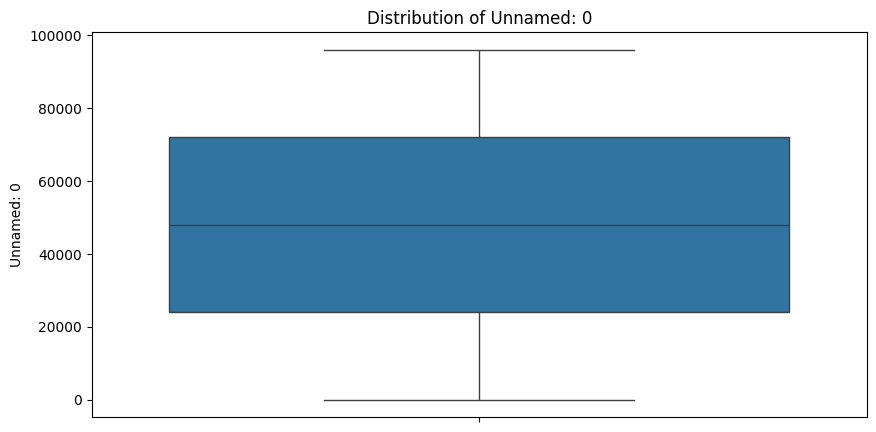

Skewness of customer_zip_code_prefix: 0.7757433935513174
Standard deviation of customer_zip_code_prefix: 29801.64809417318


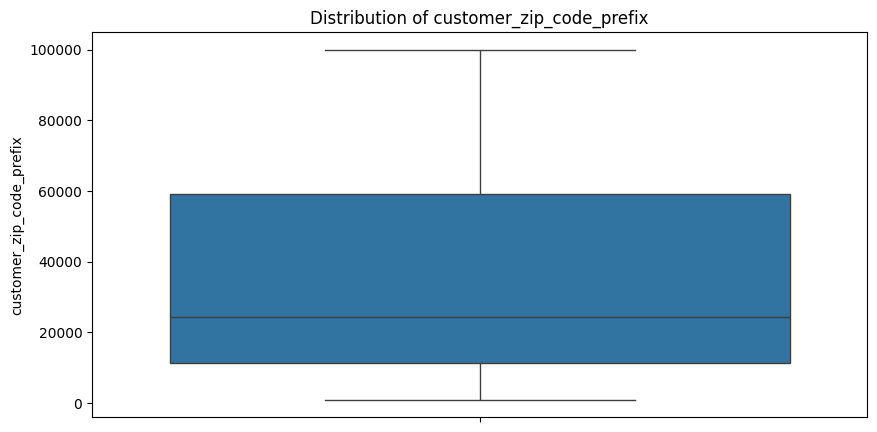

Skewness of order_id: 11.862593280003077
Standard deviation of order_id: 0.2143837547943183


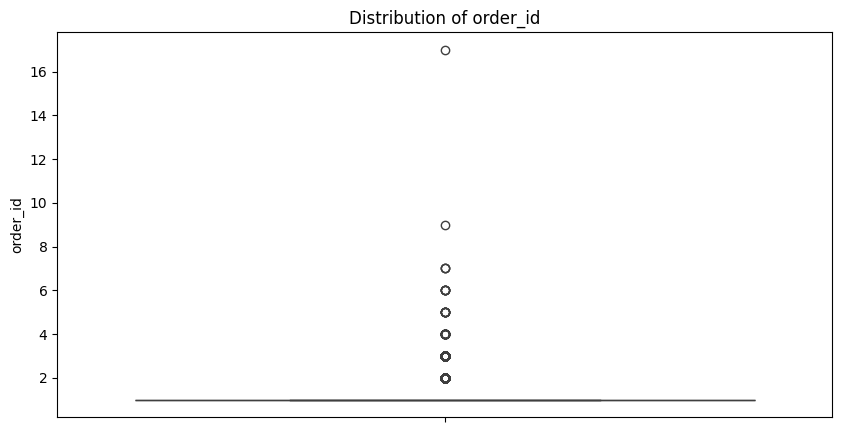

Skewness of purchased_approved: 1.658409423167035
Standard deviation of purchased_approved: 23657.084007071637


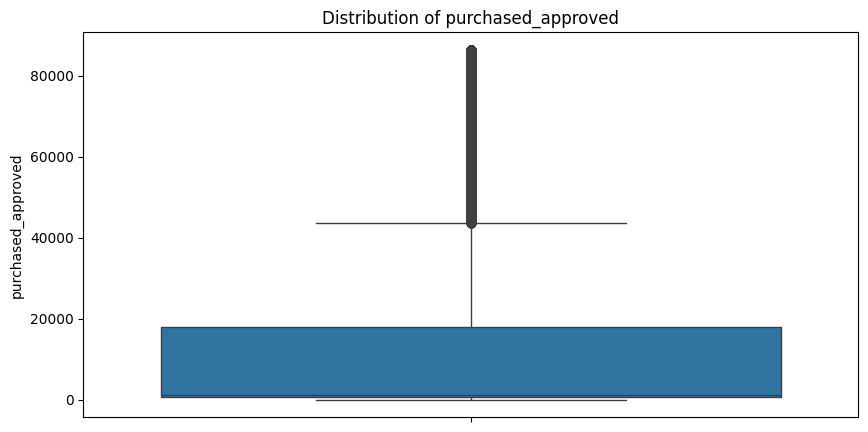

Skewness of delivered_estimated: -3.492735803747668
Standard deviation of delivered_estimated: 30.449486953828202


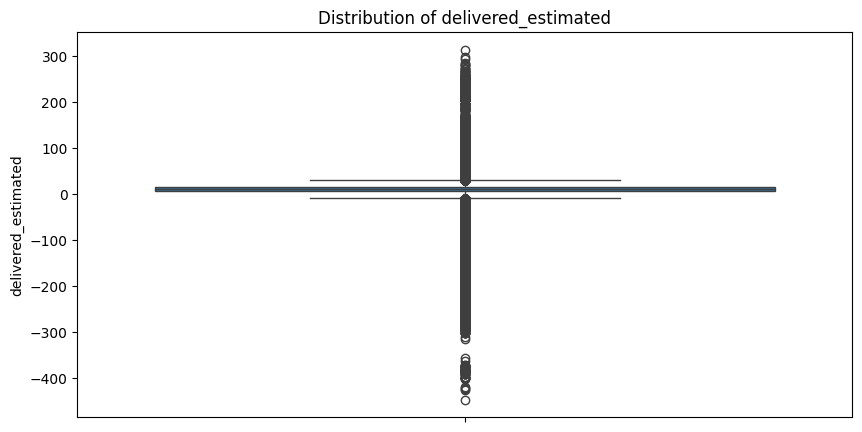

Skewness of purchased_delivered: 3.6795837296810427
Standard deviation of purchased_delivered: 30.72348800550564


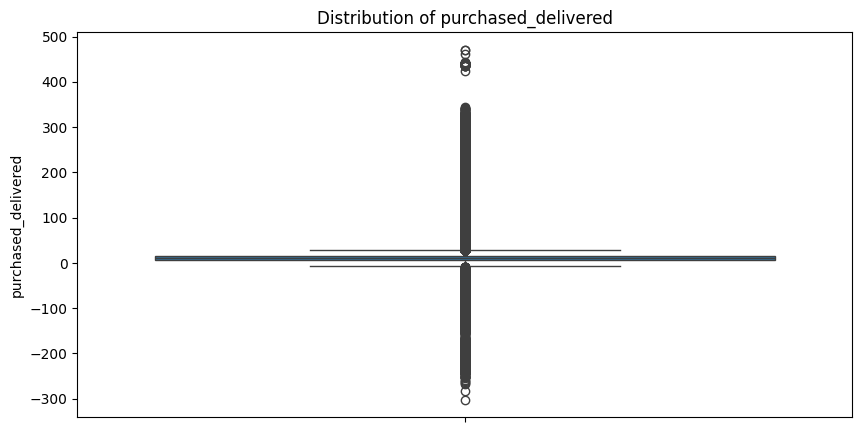

Skewness of product_id: 6.600163817912844
Standard deviation of product_id: 0.3280884722980742


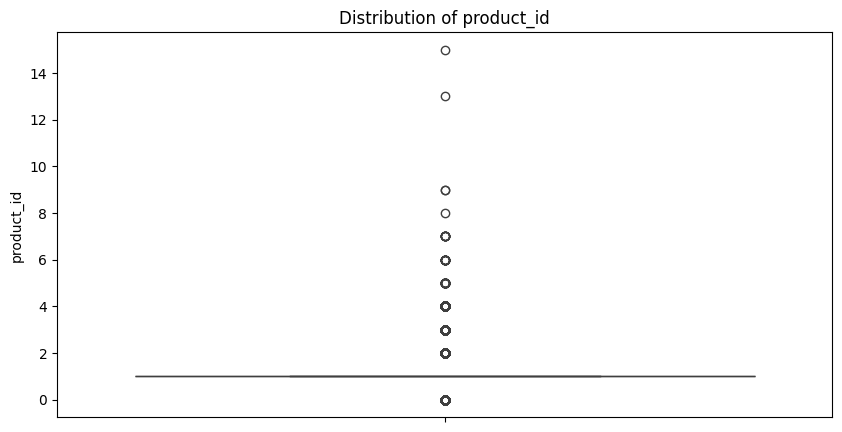

Skewness of price: 29.433948671897173
Standard deviation of price: 63271.43886790345


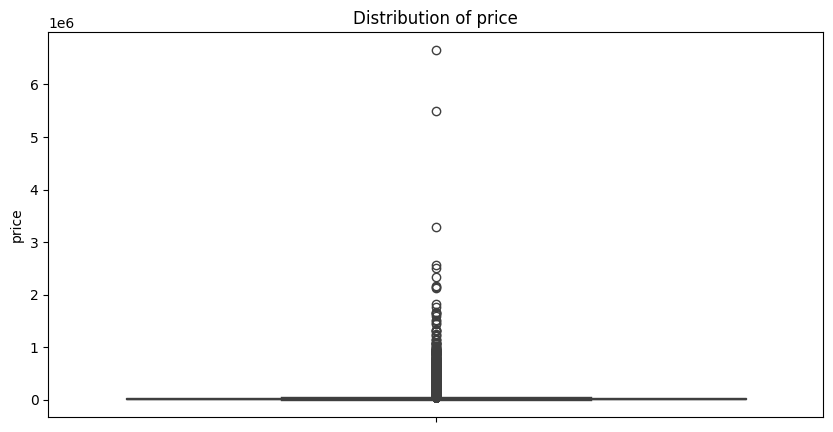

Skewness of freight_value: 23.26153211145121
Standard deviation of freight_value: 7026.622946840956


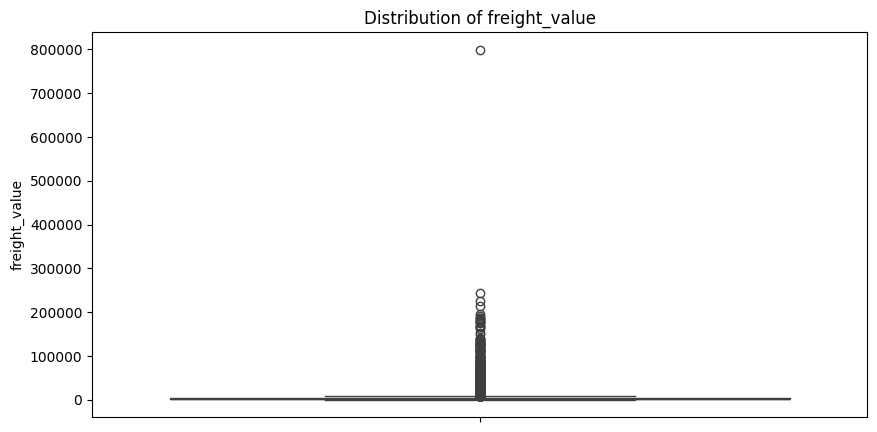

Skewness of product_weight_g: 42.17844396103747
Standard deviation of product_weight_g: 1486106.3199002494


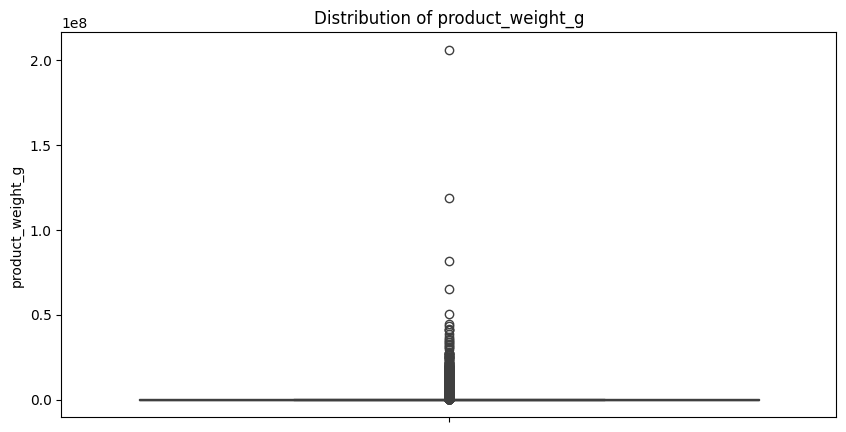

Skewness of product_length_cm: 11.965820487175028
Standard deviation of product_length_cm: 9949.452819046066


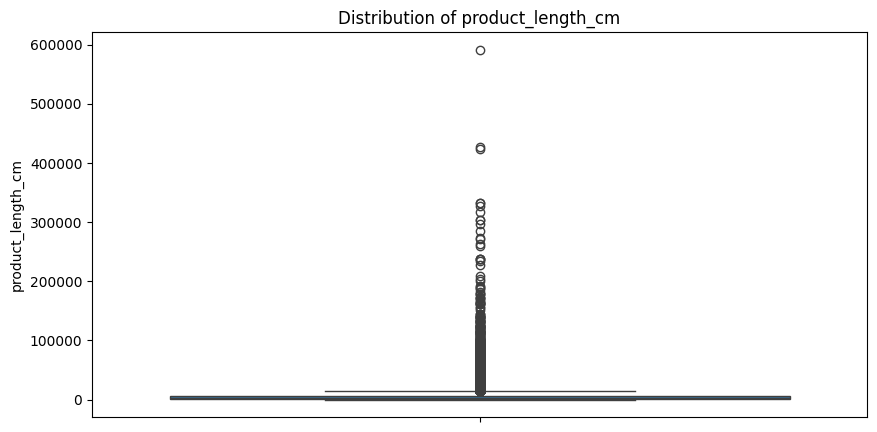

Skewness of product_height_cm: 14.677177426249566
Standard deviation of product_height_cm: 6332.266454117043


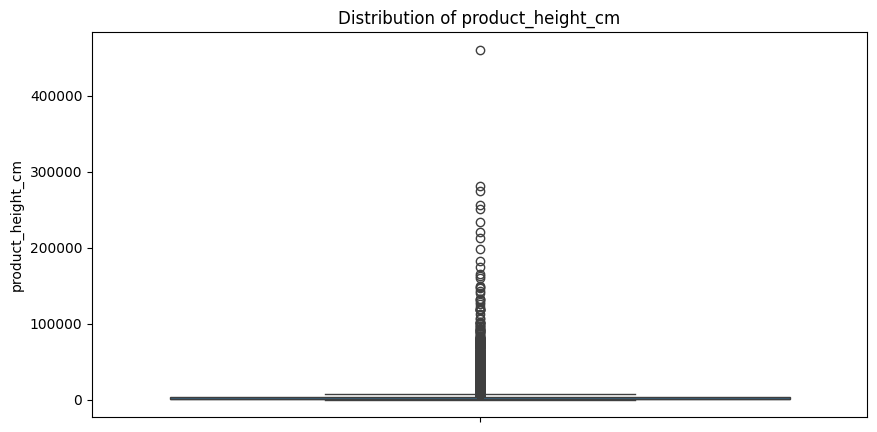

Skewness of product_width_cm: 11.59223186824621
Standard deviation of product_width_cm: 7200.956758063494


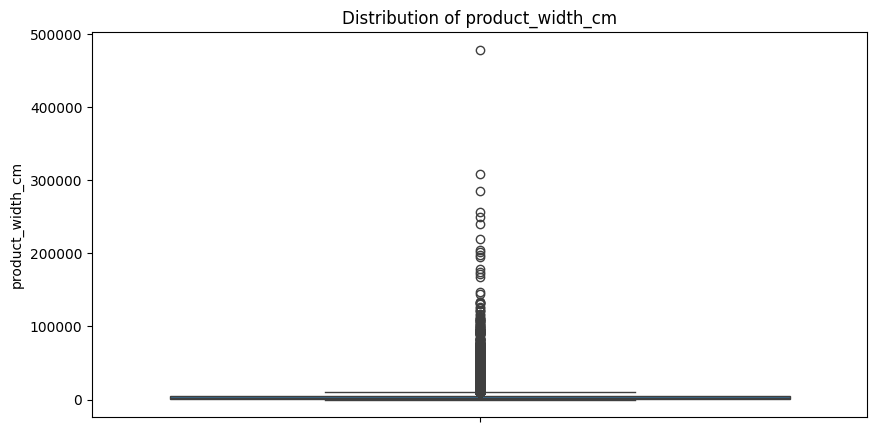

Skewness of geolocation_lat: 1.631595270481175
Standard deviation of geolocation_lat: 5.621435729526562


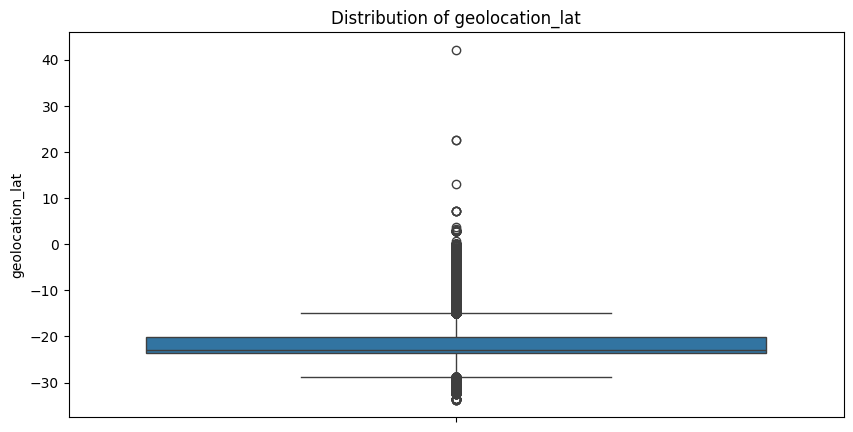

Skewness of geolocation_lng: 0.017939844544967415
Standard deviation of geolocation_lng: 4.0588322788673565


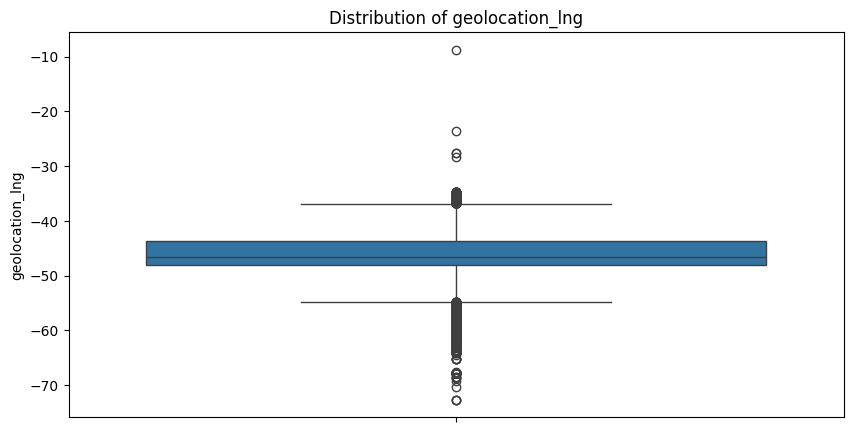

Skewness of payment_installments: 1.594304437661753
Standard deviation of payment_installments: 2.724316155626932


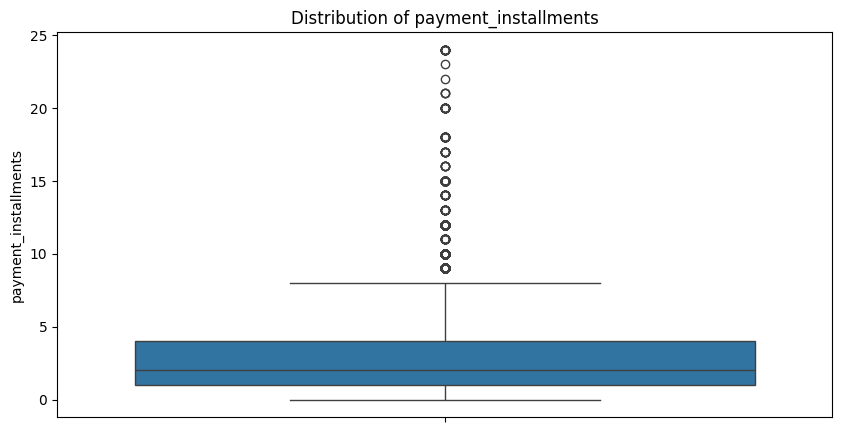

Skewness of payment_value: 52.85698821007279
Standard deviation of payment_value: 135928.30789025914


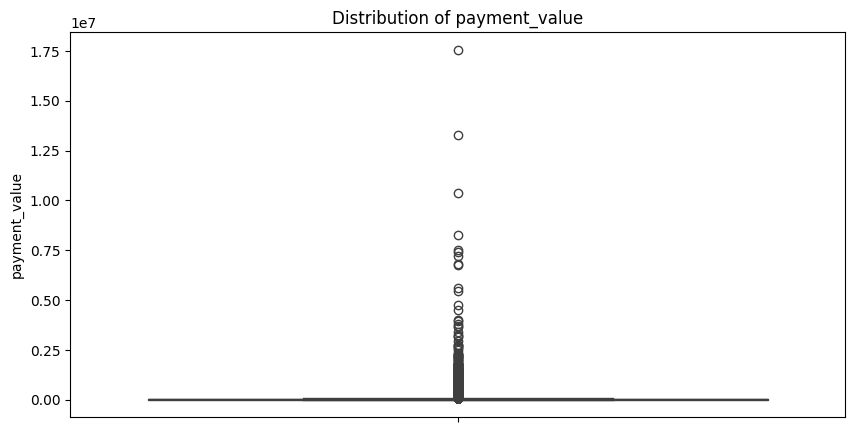

Skewness of review_score: -1.3613795801860509
Standard deviation of review_score: 1.3419908820998652


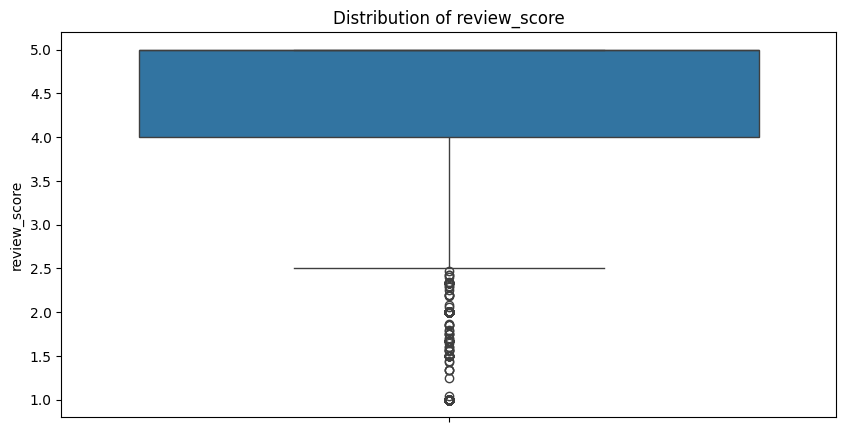

Skewness of Recency: 0.44545210864069507
Standard deviation of Recency: 153.41786878790546


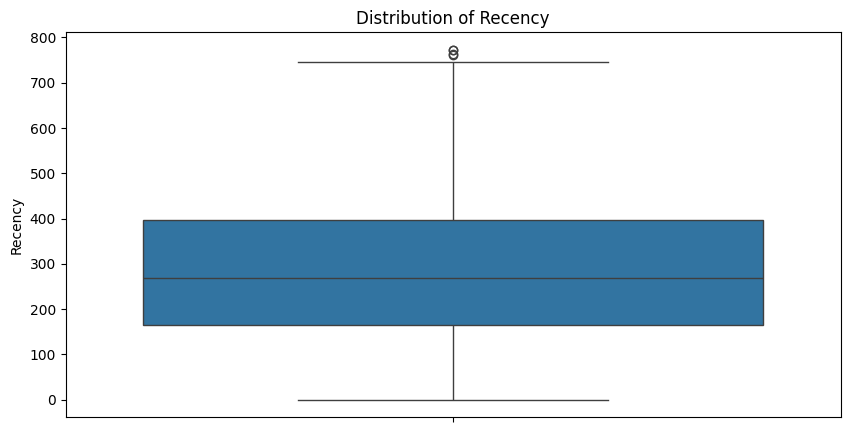

Skewness of Monetary: 68.00642725566478
Standard deviation of Monetary: 644.8919867657839


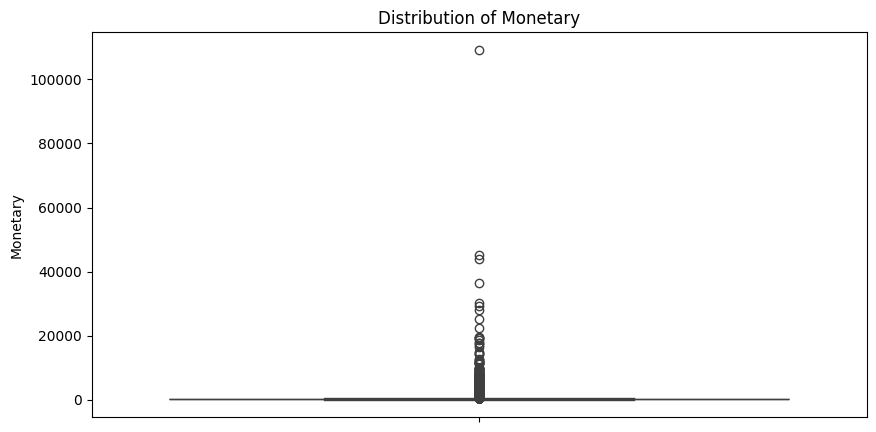

Skewness of Frequency: 11.862593280003077
Standard deviation of Frequency: 0.2143837547943183


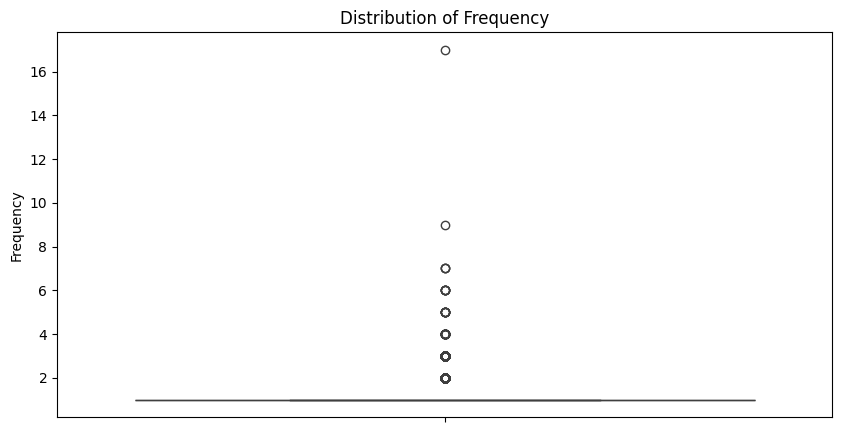

In [ ]:
for col in final.select_dtypes(include = np.number).columns:
    plt.figure(figsize = (10, 5))
    print(f'Skewness of {col}: {final[col].skew()}')
    print(f'Standard deviation of {col}: {final[col].std()}')
    sns.boxplot(final[col])
    plt.title(f'Distribution of {col}')
    plt.show()

*Insight*

- Price, payment value, and product dimensions have extreme outliers, which need transformation or removal.
- Delivery time and review scores are negatively skewed, showing early deliveries and generally high ratings.
- Geolocation and customer zip codes are mildly skewed, indicating regional concentration of customers.

In [ ]:
final.drop(columns = ['customer_zip_code_prefix', 'order_id', 'product_id', 'Frequency'], axis = 1, inplace = True)

In [ ]:
finalOutlierTreated = final.copy()

In [ ]:
for i in finalOutlierTreated.select_dtypes(include = np.number).columns:
    q1 = finalOutlierTreated[i].quantile(0.25)
    q3 = finalOutlierTreated[i].quantile(0.75)
    iqr = q3 - q1
    ul = q3 + 1.5*iqr
    ll = q1 - 1.5*iqr
    finalOutlierTreated[i] = np.where(finalOutlierTreated[i]>ul,ul,finalOutlierTreated[i])
    finalOutlierTreated[i] = np.where(finalOutlierTreated[i]<ll,ll,finalOutlierTreated[i])

Skewness of Unnamed: 0: 0.0
Standard deviation of Unnamed: 0: 27740.670071214936


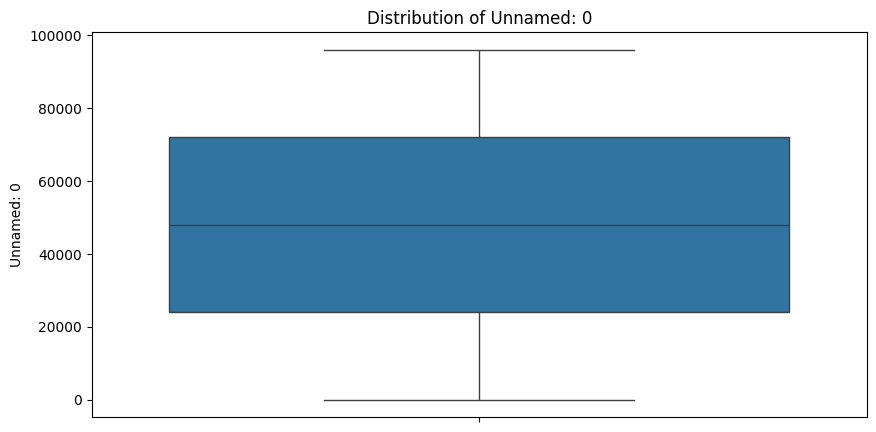

Skewness of purchased_approved: 1.2305231106620218
Standard deviation of purchased_approved: 16668.29579869504


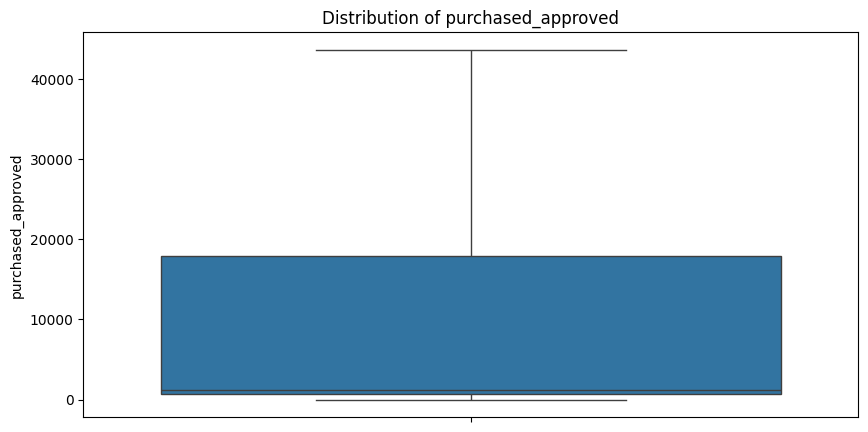

Skewness of delivered_estimated: -0.09341519941078129
Standard deviation of delivered_estimated: 8.805365619943572


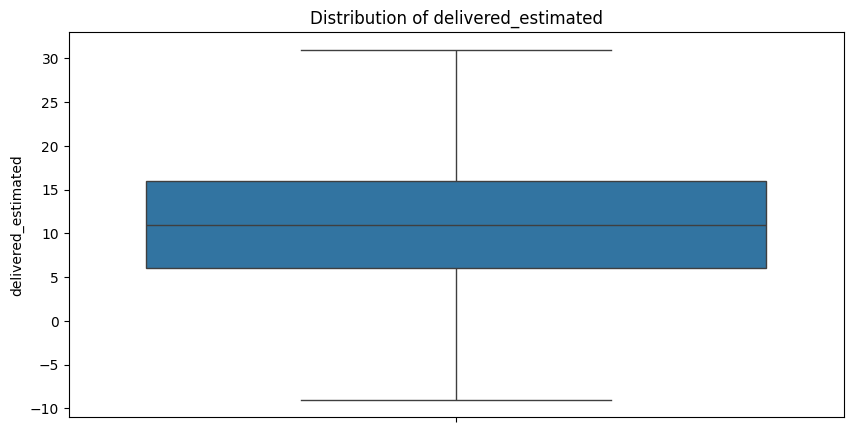

Skewness of purchased_delivered: 0.6547538413967114
Standard deviation of purchased_delivered: 7.632169531172368


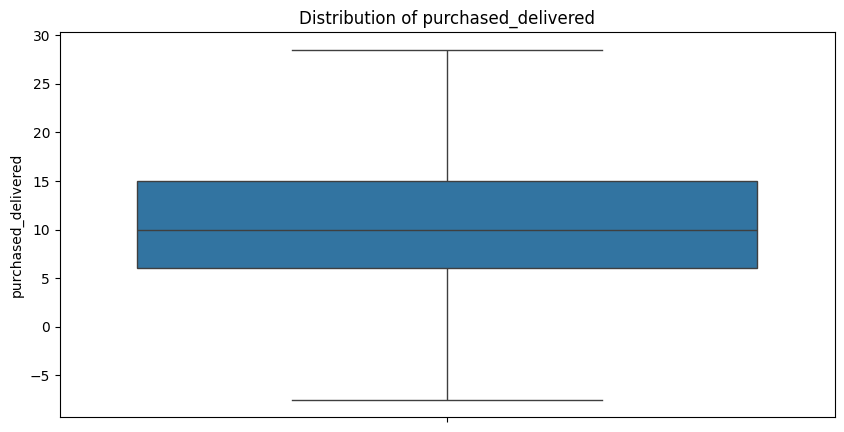

Skewness of price: 1.1663696338193277
Standard deviation of price: 15716.01752954236


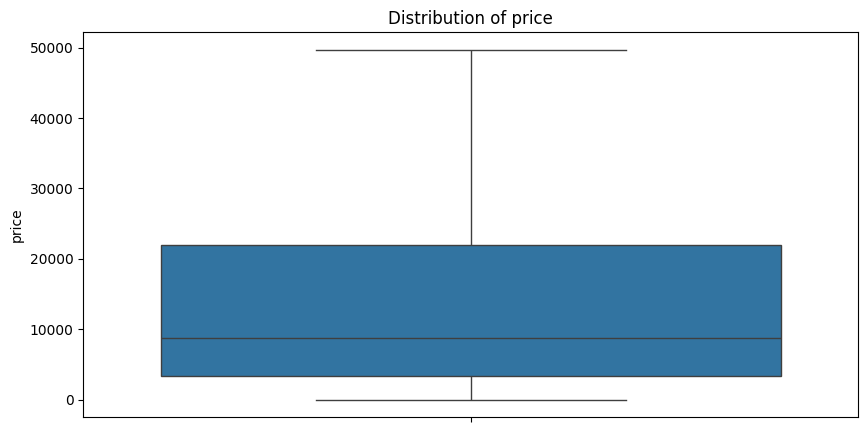

Skewness of freight_value: 1.1334941613059788
Standard deviation of freight_value: 2671.4758922000287


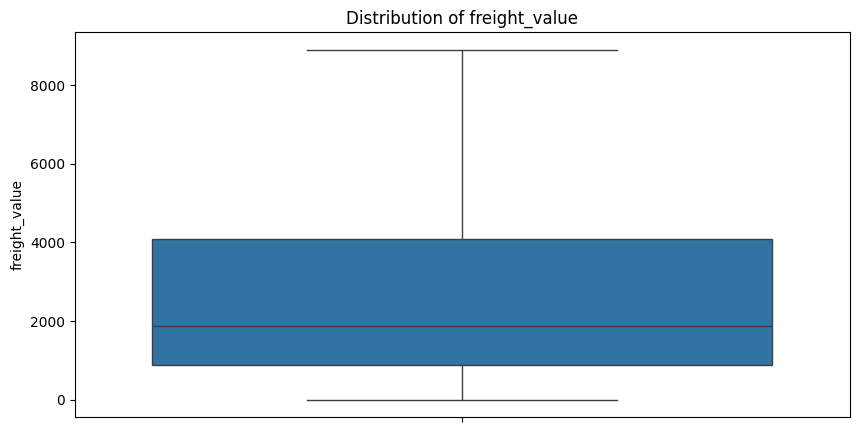

Skewness of product_weight_g: 1.1925925142322902
Standard deviation of product_weight_g: 227956.73690029976


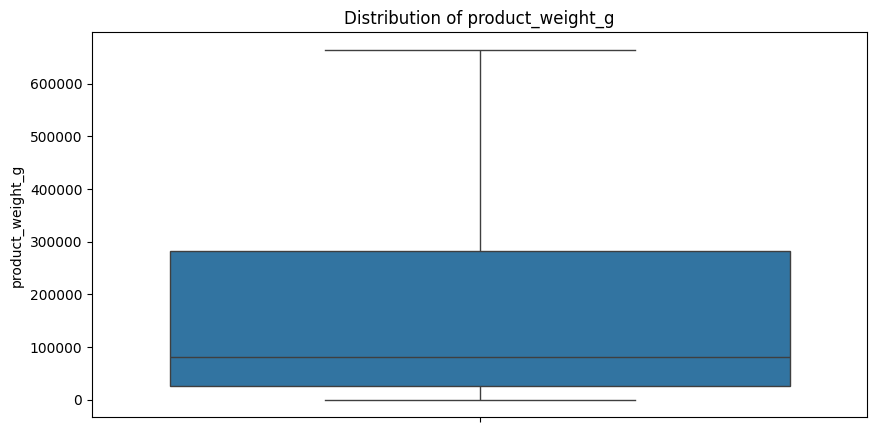

Skewness of product_length_cm: 1.1323389843489535
Standard deviation of product_length_cm: 4252.476889105289


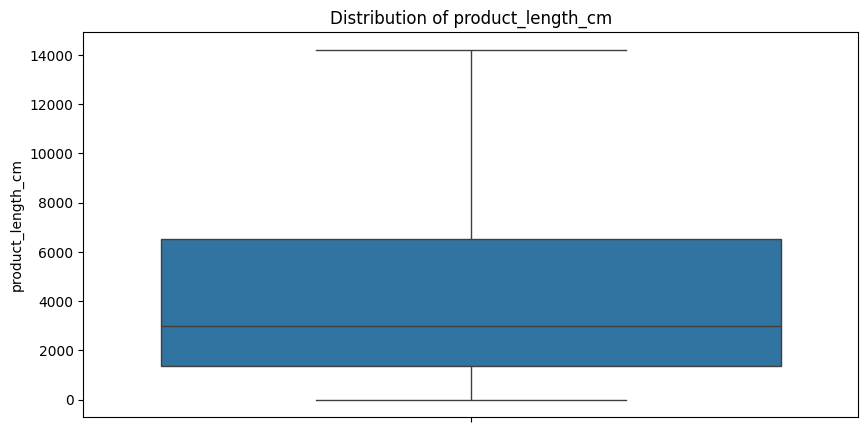

Skewness of product_height_cm: 1.1554202734240981
Standard deviation of product_height_cm: 2361.345377201033


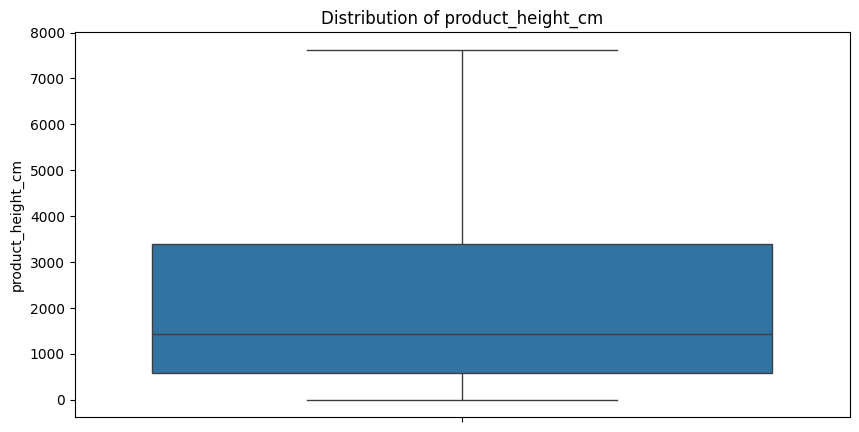

Skewness of product_width_cm: 1.1258684883330412
Standard deviation of product_width_cm: 3256.685130786384


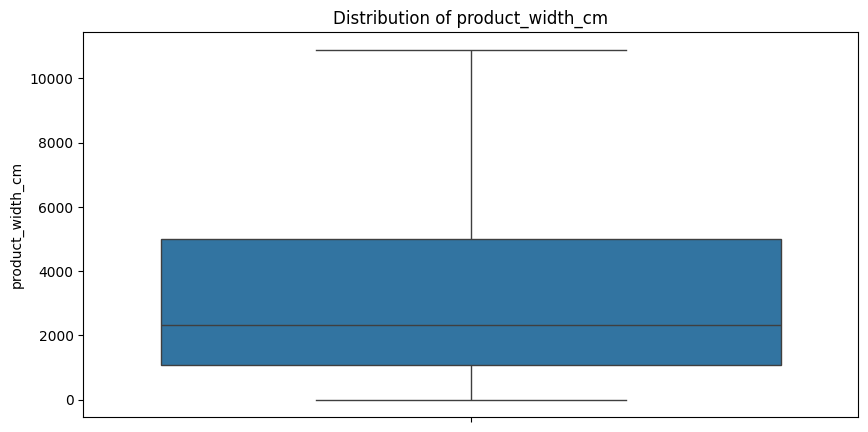

Skewness of geolocation_lat: 0.5259883138010355
Standard deviation of geolocation_lat: 3.6105820091049945


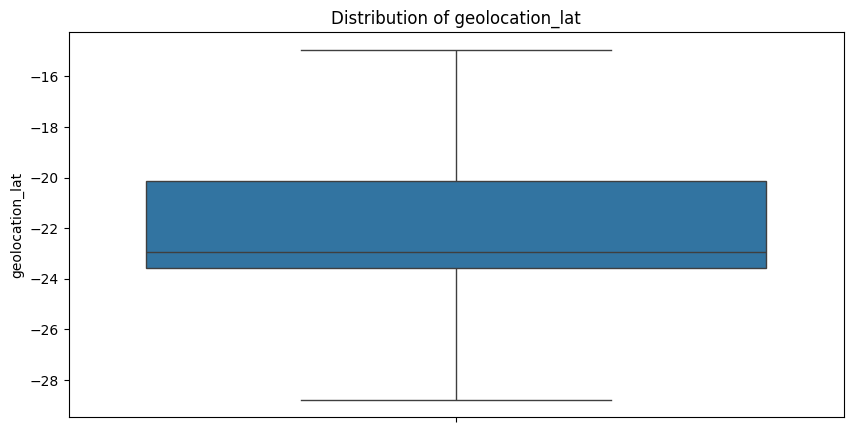

Skewness of geolocation_lng: 0.26488442408700796
Standard deviation of geolocation_lng: 3.7763803765477455


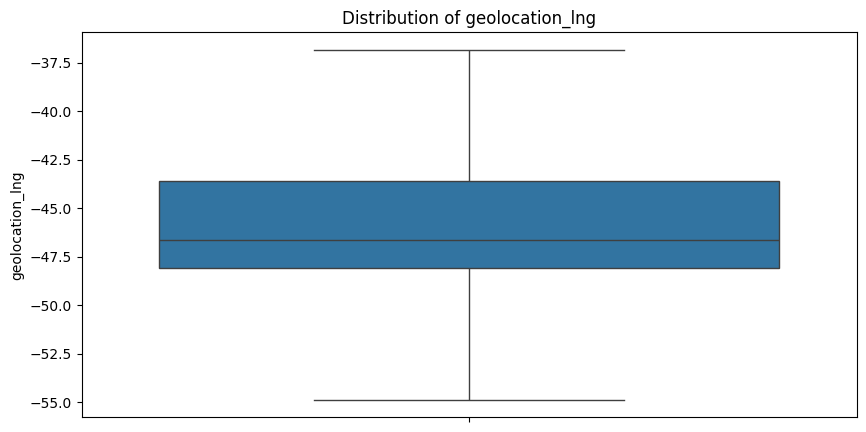

Skewness of payment_installments: 1.2131809772720943
Standard deviation of payment_installments: 2.438464714296009


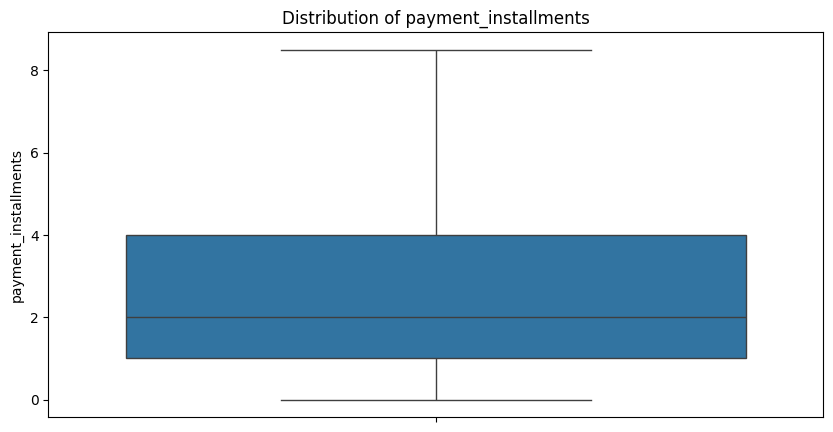

Skewness of payment_value: 1.1639340911568798
Standard deviation of payment_value: 20446.225781659712


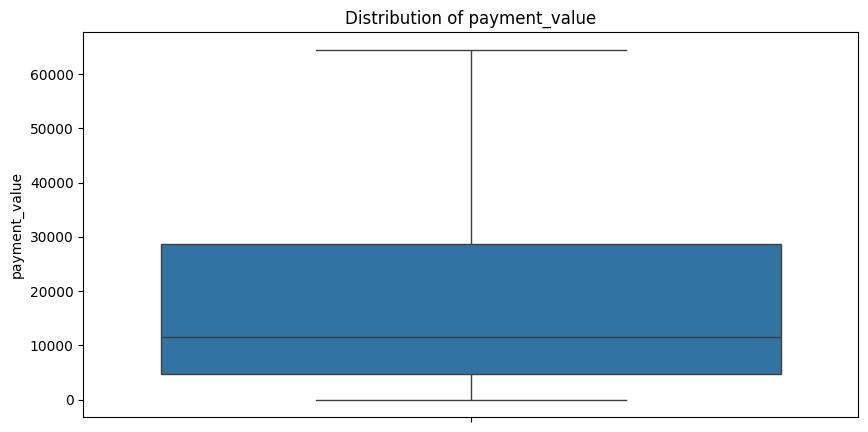

Skewness of review_score: -0.8787468723412474
Standard deviation of review_score: 0.9556100953769997


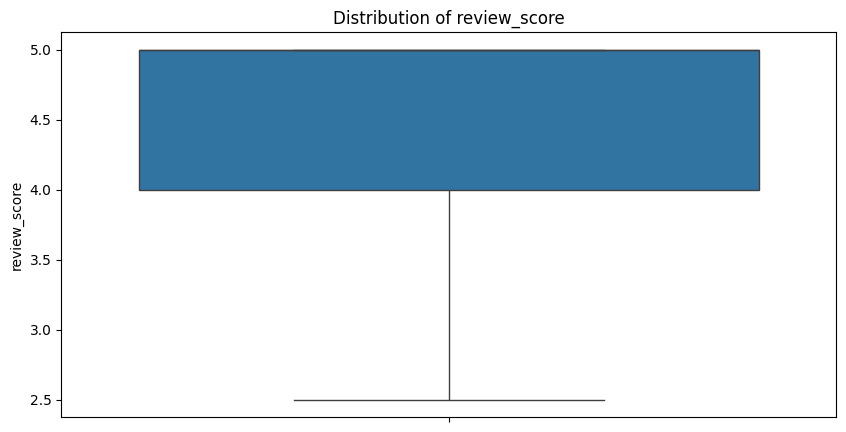

Skewness of Recency: 0.44533091047921397
Standard deviation of Recency: 153.41516147047574


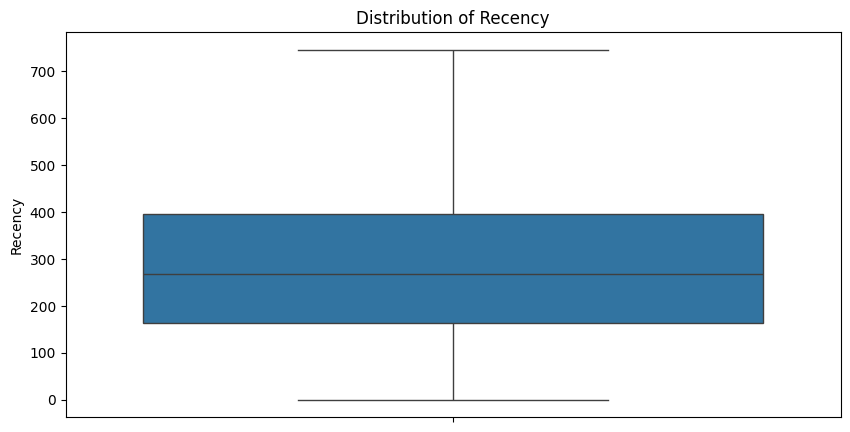

Skewness of Monetary: 1.0946958400882982
Standard deviation of Monetary: 117.98452947256257


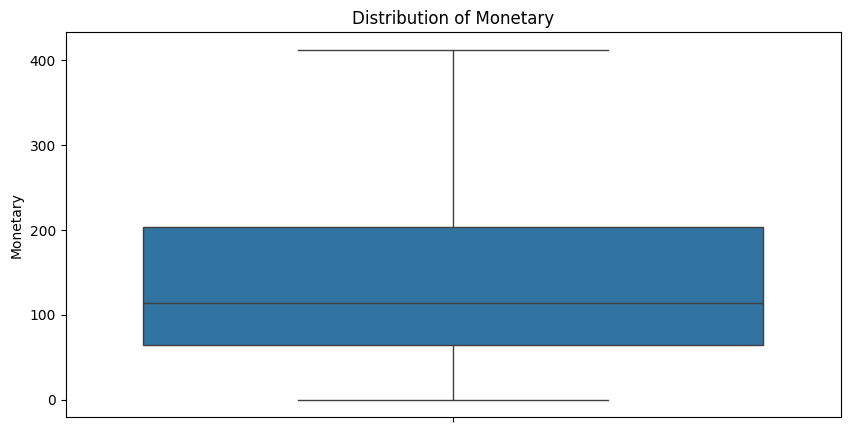

In [ ]:
for col in finalOutlierTreated.select_dtypes(include = np.number).columns:
    plt.figure(figsize = (10, 5))
    print(f'Skewness of {col}: {finalOutlierTreated[col].skew()}')
    print(f'Standard deviation of {col}: {finalOutlierTreated[col].std()}')
    sns.boxplot(finalOutlierTreated[col])
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
finalOutlierTreated.shape

(96096, 22)

*Insight*

- Improved Distribution and Reduced Skewness

Several features that were highly skewed before outlier treatment have shown a significant reduction in skewness. Features such as price, freight value, product weight, payment value, and monetary values previously exhibited extreme right-skewness. After applying the IQR method, their distributions are now closer to normal.

This improvement suggests that capping extreme values helped retain meaningful trends while removing anomalies that could have negatively impacted model performance. It ensures that these features remain useful without being dominated by a few exceptionally high values.

Similarly, the review score and delivery time variables also show a reduction in skewness, although they remain slightly negatively skewed. This suggests that delivery times are more often shorter than expected rather than excessively delayed. It also indicates that customer review scores tend to be more positive, with fewer extremely low ratings.

- Features That Still Show Moderate Skewness

Despite the improvements, some features still exhibit moderate skewness. These include purchase approval time, payment installments, geolocation (latitude and longitude), recency, and product dimensions (length, height, and width).

While the IQR method helped cap extreme values, these features may still benefit from additional transformations. One possible approach is log transformation, which can help further reduce right skewness. Another approach is standardization, which can bring the feature distributions closer to a normal shape, making them more suitable for machine learning models.

### *Missing Value*

In [ ]:
finalOutlierTreated.isna().sum() / len(final) * 100

,0
Unnamed: 0,0.000000
customer_unique_id,0.000000
customer_city,0.000000
customer_state,0.000000
purchased_approved,0.000000
delivered_estimated,0.000000
purchased_delivered,0.000000
price,0.000000
freight_value,0.000000
product_weight_g,0.000000


In [ ]:
finalOutlierTreated.drop(columns = ['review_score'], axis = 1, inplace = True)

In [ ]:
finalOutlierTreated.drop(columns=['Unnamed: 0'], inplace=True)


In [ ]:
# List of numerical columns to fill with median
num_cols = [
    "geolocation_lat", "geolocation_lng", "payment_installments"
]

# Fill numerical columns with median
for col in num_cols:
    if col in finalOutlierTreated:
        finalOutlierTreated[col].fillna(finalOutlierTreated[col].median(), inplace=True)

# Fill categorical columns with mode
cat_cols = ["payment_type"]
for col in cat_cols:
    if col in finalOutlierTreated:
        finalOutlierTreated[col].fillna(finalOutlierTreated[col].mode()[0], inplace=True)

# Check if all missing values are filled
print(finalOutlierTreated.isna().sum())

customer_unique_id      0
customer_city           0
customer_state          0
purchased_approved      0
delivered_estimated     0
purchased_delivered     0
price                   0
freight_value           0
product_weight_g        0
product_length_cm       0
product_height_cm       0
product_width_cm        0
geolocation_lat         0
geolocation_lng         0
payment_type            0
payment_installments    0
payment_value           0
Recency                 0
Monetary                0
Churn                   0
dtype: int64


<ipython-input-116-f751a6e37ad6>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  finalOutlierTreated[col].fillna(finalOutlierTreated[col].median(), inplace=True)
<ipython-input-116-f751a6e37ad6>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

*Insight*

The missing values were handled using median imputation for numerical columns and mode imputation for categorical columns. Median was chosen to prevent distortion from outliers, ensuring stability for features like geolocation coordinates, payment installments, and review scores. Mode imputation for payment type maintains consistency by filling in the most frequent value.

A final check confirmed that all missing values were successfully filled, making the dataset ready for further analysis. Additional validation, such as distribution checks and correlation analysis, is recommended to ensure data integrity.

## Export Final Data


In [ ]:
finalOutlierTreated.to_csv('finalOutlierTreated.csv')

In [ ]:
finalOutlierTreated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95828 entries, 0 to 96095
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    95828 non-null  object 
 1   customer_city         95828 non-null  object 
 2   customer_state        95828 non-null  object 
 3   purchased_approved    95828 non-null  float64
 4   delivered_estimated   95828 non-null  float64
 5   purchased_delivered   95828 non-null  float64
 6   price                 95828 non-null  float64
 7   freight_value         95828 non-null  float64
 8   product_weight_g      95828 non-null  float64
 9   product_length_cm     95828 non-null  float64
 10  product_height_cm     95828 non-null  float64
 11  product_width_cm      95828 non-null  float64
 12  geolocation_lat       95828 non-null  float64
 13  geolocation_lng       95828 non-null  float64
 14  payment_type          95828 non-null  object 
 15  payment_installments  95

*Insight*

- The dataset captures customer purchase behavior well, incorporating order frequency, spending habits, and delivery experience.

- The Churn variable was created using a simple recency-based approach, which could be refined using more advanced techniques.

- Handling outliers and missing values ensures data consistency but may affect certain statistical properties.

